### May need some other informative cols we dropped previously:

- studio
- language
- year

In [2]:
import pandas as pd
import numpy as np

import sqlite3

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats

pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

# adds commas to large nums
pd.options.display.float_format = '{:,.2f}'.format

# seaborn plot styles
sns.set_style('darkgrid')
sns.set_context('talk')
palette = sns.color_palette('mako', 10)
palette

[(0.13701138, 0.08259683, 0.15060265),
 (0.20976258, 0.14925954, 0.29687795),
 (0.25007383, 0.22365053, 0.45519562),
 (0.23807973, 0.32226344, 0.58941872),
 (0.21112526, 0.42903064, 0.6266318),
 (0.20418396, 0.53013715, 0.64946117),
 (0.20968223, 0.63088252, 0.6701105),
 (0.26604085, 0.73564353, 0.67914062),
 (0.4285828, 0.82635051, 0.6780564),
 (0.68051833, 0.88963189, 0.75150483)]

In [2]:
df = pd.read_csv('data/final_df.csv', index_col=0)
df = df[df.genre.notnull()]

In [3]:
# get list of all genres in df['genre']
genres = sorted(list(set([genre for genres in df['genre'] if isinstance(genres, str) for genre in genres.split()])))
genres.remove('TV')
genres.remove('movie')

# add binary genre cols
for genre in genres:
    df.loc[:, genre] = df['genre'].apply(lambda x: 1 if genre in x.split() else 0)

In [4]:
print(df.shape)
df.iloc[:, :14].info()

(2385, 34)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2385 entries, 19 to 141143
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              2385 non-null   object 
 1   runtime            1997 non-null   float64
 2   primary_name       2137 non-null   object 
 3   studio             1183 non-null   object 
 4   popularity         1913 non-null   float64
 5   vote_average       1913 non-null   float64
 6   vote_count         1913 non-null   float64
 7   release_date       2385 non-null   object 
 8   production_budget  2385 non-null   float64
 9   worldwide_gross    2385 non-null   float64
 10  month              2385 non-null   float64
 11  year               2385 non-null   float64
 12  roi                2385 non-null   float64
 13  genre              2385 non-null   object 
dtypes: float64(9), object(5)
memory usage: 279.5+ KB


# Look at overall distribution of genres

In [143]:
genre_counts = df.iloc[:, 14:-1].sum().sort_values().to_frame()
genre_counts.columns = ['count']

# the chance that a movie in our datset is classified as that genre
genre_counts['percent'] = round((genre_counts['count'] / 2385) * 100, 1)

In [144]:
genre_counts

,count,percent
Western,27,1.10
Sport,48,2.00
War,64,2.70
Musical,85,3.60
History,104,4.40
Animation,136,5.70
Biography,173,7.30
Documentary,183,7.70
Fantasy,232,9.70
Mystery,235,9.90


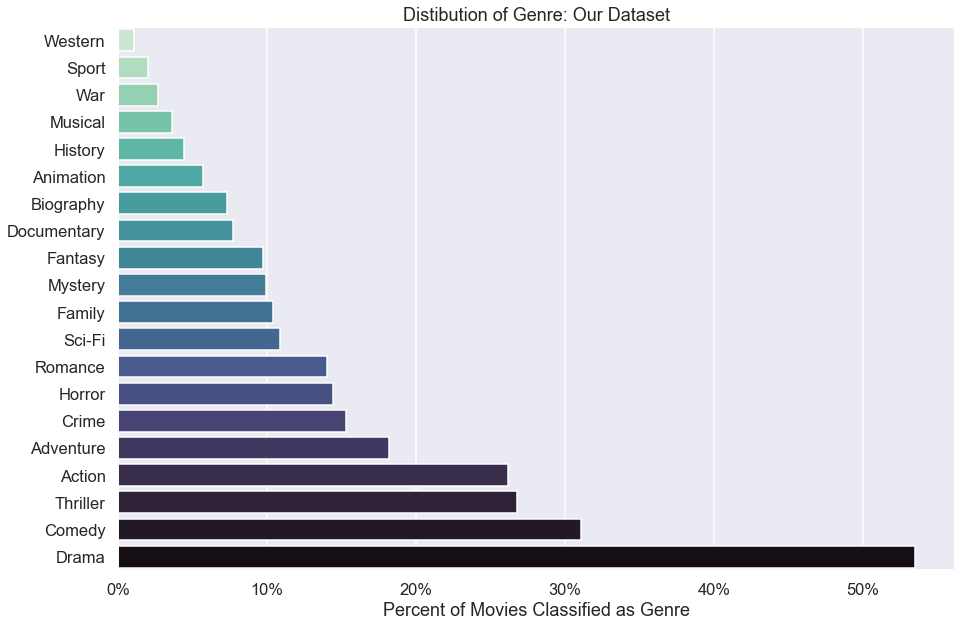

In [145]:
plt.figure(figsize=(15, 10))

sns.barplot(y=genre_counts.index, x=genre_counts['percent'], palette='mako_r')

plt.title('Distibution of Genre: Our Dataset')
plt.ylabel('')
plt.xlabel('Percent of Movies Classified as Genre')

plt.xticks(ticks=[0, 10, 20, 30, 40, 50], labels=['0%', '10%', '20%', '30%', '40%', '50%'])

plt.savefig('plots/genre_dist', dpi=150);

### Genre distribution:
- Keep in mind, most movies are classified with 2-4 genres. 
- 53% of the movies in our dataset were classified as Drama
- Sport, War, Musical, and History were underrepresented in our data (all below 5%)

# Bin movies by ROI
- positive (ROI > 0)
- negative (ROI < 0)
- 100% profit (ROI > 1)

In [43]:
# any movies that broke even?
df.query(" roi == 0 ").shape

(0, 34)

In [197]:
made_money = df.query(" roi > 0 ")
lost_money = df.query(" roi < 0 ")
greater_than_1 = df.query(" roi > 1 ")

print(f'We have {made_money.shape[0]} ({made_money.shape[0]/df.shape[0]*100:.1f}%) movies that made money (ROI > 0).')
print(f'We have {lost_money.shape[0]} ({lost_money.shape[0]/df.shape[0]*100:.1f}%) movies that lost money. (ROI < 0).')
print(f'We have {greater_than_1.shape[0]} ({greater_than_1.shape[0]/df.shape[0]*100:.1f}%) movies that made 100% profit (ROI > 1).')

We have 1479 (62.0%) movies that made money (ROI > 0).
We have 906 (38.0%) movies that lost money. (ROI < 0).
We have 1071 (44.9%) movies that made 100% profit (ROI > 1).


## Movies that made money

In [220]:
# made money (positive ROI)
pos_melted = made_money.melt(id_vars=['roi'], value_vars=genres, var_name='genre', value_name='is_genre')
pos_melted = pos_melted[pos_melted['is_genre'] == 1].drop(['is_genre'], axis=1).sort_values('roi')

pos_means = pos_melted.groupby('genre')['roi'].mean().to_frame().sort_values('roi', ascending=False)

In [221]:
pos_means

,roi
genre,
Horror,9.95
Documentary,7.39
Biography,6.79
Mystery,6.66
Thriller,6.00
Animation,5.04
Sport,4.28
Musical,4.13
Romance,4.06


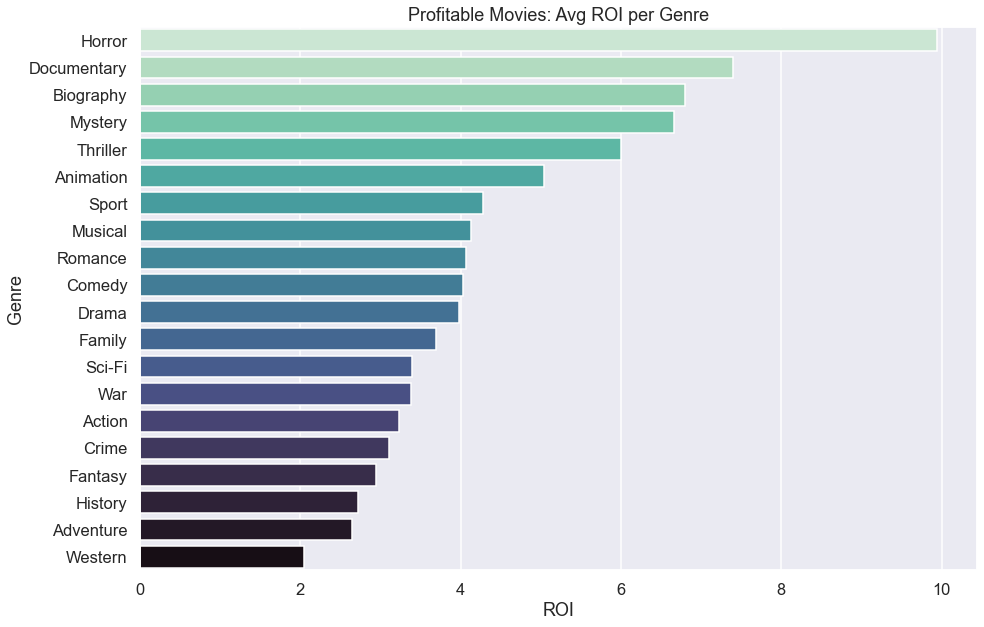

In [199]:
plt.figure(figsize=(15, 10))

sns.barplot(y=pos_means.index, x=pos_means['roi'], palette='mako_r')

plt.title('Profitable Movies: Avg ROI per Genre')
plt.ylabel('Genre')
plt.xlabel('ROI')

plt.savefig('plots/prof_movies_95', dpi=150);

In [200]:
# counts of each genre from made_money
pos_counts = pos_melted.groupby('genre')['roi'].count().to_frame().sort_values('roi', ascending=False)
pos_counts.columns = ['count']

In [201]:
# shows what percent of the movies that made money pertained to each genre
pos_counts['percent'] = round(pos_counts['count'] / 1479 * 100, 1)
pos_counts

,count,percent
genre,,
Drama,740,50.00
Comedy,498,33.70
Action,424,28.70
Thriller,378,25.60
Adventure,330,22.30
Romance,212,14.30
Crime,208,14.10
Horror,201,13.60
Family,199,13.50


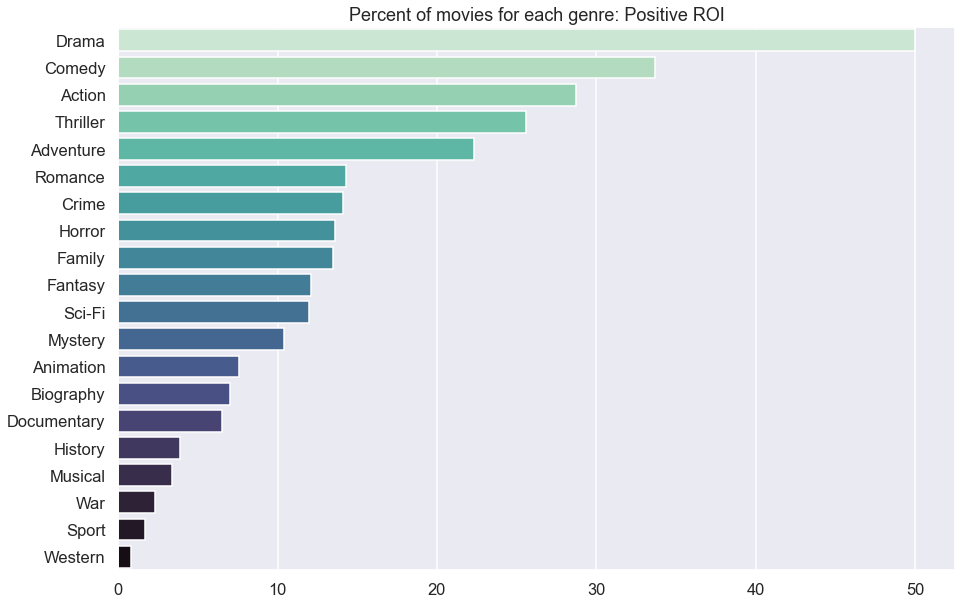

In [202]:
plt.figure(figsize=(15, 10))

sns.barplot(y=pos_counts.index, x=pos_counts['percent'], palette='mako_r')

plt.title('Percent of movies for each genre: Positive ROI')
plt.ylabel('')
plt.xlabel('');

## Movies with positive ROI:
### p(genre | profitable)
__Top 5 (Good recs):__
- 50% were classified as "Drama"
- 34% were classified as "Comedy"
- 29% were classified as "Action"
- 26% were classified as "Thriller"
- 22% were classified as "Adventure"

__Bottom 5 (Bad recs):__
- 1% were classified as "Western"
- 2% were classified as "Sport", or "War"
- 3% were classified as "Musical"
- 4% were classified as "History"

In [223]:
# lost money (negative ROI)
neg_melted = lost_money.melt(id_vars=['roi'], value_vars=genres, var_name='genre', value_name='is_genre')
neg_melted = neg_melted[neg_melted['is_genre'] == 1].drop(['is_genre'], axis=1).sort_values('roi')

neg_means = neg_melted.groupby('genre')['roi'].median().to_frame().sort_values('roi', ascending=False)

In [224]:
neg_means

,roi
genre,
Musical,-0.63
History,-0.67
Biography,-0.71
Adventure,-0.72
Fantasy,-0.77
Western,-0.77
Crime,-0.77
War,-0.78
Animation,-0.78


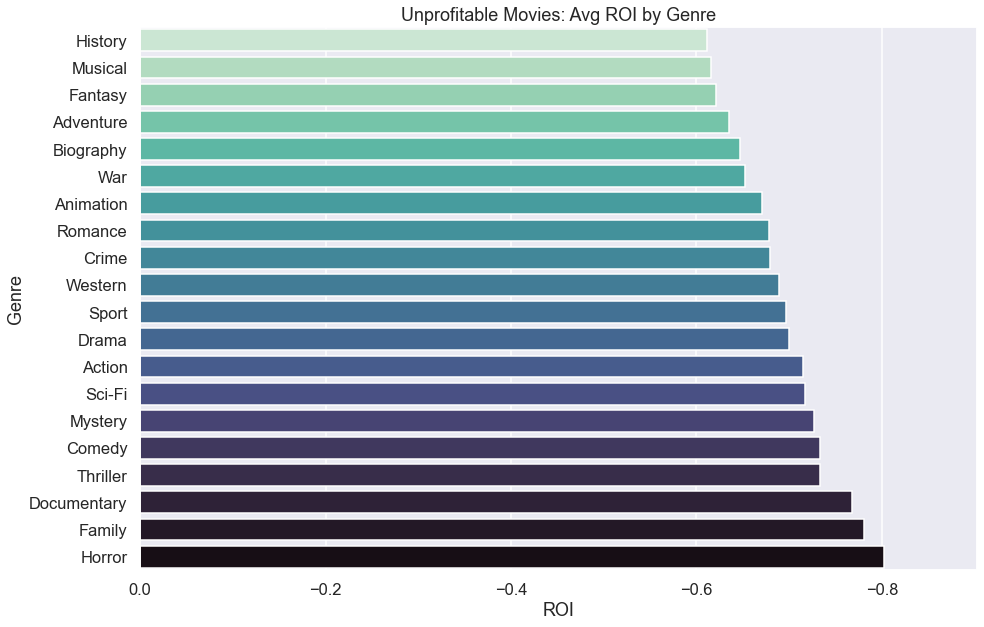

In [204]:
plt.figure(figsize=(15, 10))

plot = sns.barplot(y=neg_means.index, x=neg_means['roi'], palette='mako_r')
plot.set_xlim(0, min(neg_means['roi']) - 0.1)

plt.title('Unprofitable Movies: Avg ROI by Genre')
plt.ylabel('Genre')
plt.xlabel('ROI');

In [205]:
# counts of each genre from lost_money
neg_counts = neg_melted.groupby('genre')['roi'].count().to_frame().sort_values('roi', ascending=False)
neg_counts.columns = ['neg_count']

In [206]:
# shows what percent of the movies that lost money pertained to each genre
neg_counts['percent'] = neg_counts['neg_count'] / 1479
neg_counts

,neg_count,percent
genre,,
Drama,535,0.36
Thriller,262,0.18
Comedy,244,0.16
Action,201,0.14
Crime,158,0.11
Horror,142,0.10
Romance,123,0.08
Adventure,104,0.07
Documentary,87,0.06


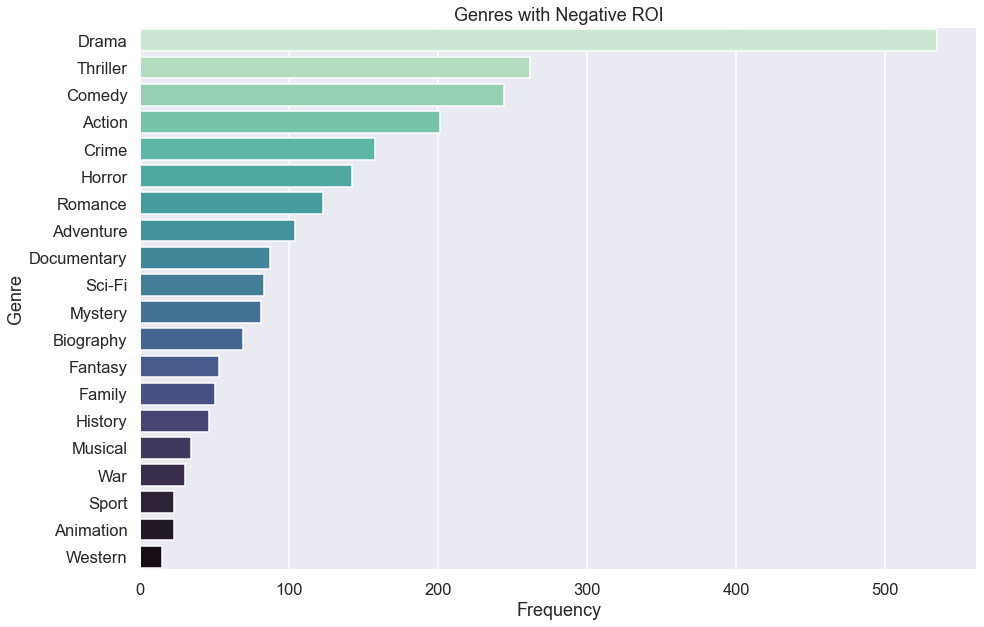

In [207]:
plt.figure(figsize=(15, 10))

sns.barplot(y=neg_counts.index, x=neg_counts['neg_count'], palette='mako_r')

plt.title('Genres with Negative ROI')
plt.ylabel('Genre')
plt.xlabel('Frequency');

## Movies with negative ROI:
__Top 5 (Bad recs):__
- 36% were classified as "Drama"
- 18% were classified as "Thriller"
- 16% were classified as "Comedy"
- 14% were classified as "Action"
- 11% were classified as "Crime"

__Bottom 5 (Good recs):__
- 1% were classified as "Western"
- 2% were classified as "Animation", "Sport", "War", or "Musical"

# What is each genre's chance of being profitable? (profitable | genre)
p(profitable | genre) = (p(genre | profitable) * p(profitable)) / p(genre)

In [208]:
p_genre_given_prof = pos_counts['percent'].sort_index() / 100
p_prof = made_money.shape[0]/df.shape[0]
p_genre = genre_counts['percent'].sort_index() / 100

p_prof_given_genre = ((p_genre_given_prof * p_prof) / p_genre).sort_values(ascending=False).to_frame()
p_prof_given_genre

,percent
genre,
Animation,0.83
Family,0.80
Fantasy,0.77
Adventure,0.76
Sci-Fi,0.68
Action,0.68
Comedy,0.67
Mystery,0.65
Romance,0.63


### Good recs:
- Given a movie is classified as "Animation" it has an 83% chance of being profitable.
- Given a movie is classified as "Family" it has an 80% chance of being profitable.
- Given a movie is classified as "Fantasy" it has an 77% chance of being profitable.
- Given a movie is classified as "Adventure" it has an 76% chance of being profitable.

# What is each individual genre's chance of being unprofitable?


In [209]:
p_unprof_given_genre = (1 - p_prof_given_genre)
p_unprof_given_genre

,percent
genre,
Animation,0.17
Family,0.20
Fantasy,0.23
Adventure,0.24
Sci-Fi,0.32
Action,0.32
Comedy,0.33
Mystery,0.35
Romance,0.37


# Genres with over 70% chance of being profitable (safest picks):
- Animation - 83%
- Family - 80%
- Fantasy - 77%
- Adventure - 76%

# Now that we have the safest picks, what genres lead to highest ROI?
- Also look at genre combinations

# Does production cost correlate with ROI?

In [185]:
df.corr()[['roi']].head(9)

,roi
runtime,-0.02
popularity,0.07
vote_average,0.03
vote_count,0.10
production_budget,-0.04
worldwide_gross,0.10
month,0.01
year,-0.16
roi,1.00


ROI appears to not have a correlation with any of the numerical variables (all corr vals are close to 0).

# Bin movies by production_cost

In [61]:
# movies with production cost over 100 mil
prod_big = df.query("production_budget >= 1e8")
prod_big.shape

(241, 34)

In [62]:
# movies with production cost between 10 mil and 100 mil
prod_med = df.query("1e7 <= production_budget < 1e8")
prod_med.shape

(1316, 34)

In [63]:
# movies with production cost less than 10 mil
prod_small = df.query("production_budget < 1e7")
prod_small.shape

(828, 34)

# Look at ROI, find outliers

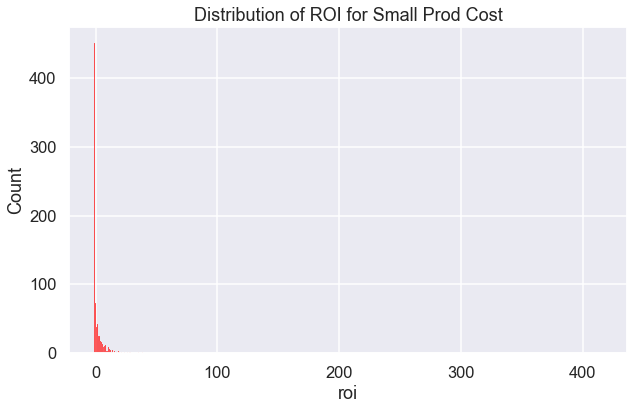

In [64]:
# Small Prod Cost
plt.figure(figsize=(10,6))
plt.title('Distribution of ROI for Small Prod Cost')
sns.histplot(data=prod_small, x='roi', color='red');

In [65]:
# small outliers
print('Budget < 10m')
print(f'95th percentile of ROI: {np.percentile(prod_small["roi"], 95):.2f}')
print(f'{100 - stats.percentileofscore(prod_small["roi"], 0):.1f}% break even (has ROI > {0})')
print(f'{100 - stats.percentileofscore(prod_small["roi"], 1):.1f}% make 100% profit (has ROI > {1})')

Budget < 10m
95th percentile of ROI: 18.69
43.6% break even (has ROI > 0)
33.3% make 100% profit (has ROI > 1)


In [66]:
# small films
prod_small['roi'].describe()

count   828.00
mean      4.14
std      22.11
min      -1.00
25%      -1.00
50%      -0.54
75%       2.51
max     415.56
Name: roi, dtype: float64

In [67]:
# left 95%
small_95 = prod_small.query(" roi < 18.69 ").sort_values('roi', ascending=False)

print(f'{small_95.shape}')
small_95['roi'].describe()

(786, 34)


count   786.00
mean      1.13
std       3.56
min      -1.00
25%      -1.00
50%      -0.66
75%       1.67
max      18.59
Name: roi, dtype: float64

In [68]:
# right 5% (outliers)
small_5 = prod_small.query(" roi > 18.69 ").sort_values('roi', ascending=False)

print(f'{small_5.shape}')
small_5['roi'].describe()

(42, 34)


count    42.00
mean     60.46
std      78.73
min      18.74
25%      25.04
50%      33.48
75%      57.33
max     415.56
Name: roi, dtype: float64

In [71]:
small_5[['title', 'primary_name', 'roi', 'genre', 'month', 'year']]

,title,primary_name,roi,genre,month,year
129447,The Gallows,NaN,415.56,Thriller Horror,7.00,"2,015.00"
46115,Bambi,Sébastien Lifshitz,311.35,Documentary Biography,8.00,"1,942.00"
52330,Rocky,Sujit Mondal,224.00,Comedy Action Drama,11.00,"1,976.00"
114042,Snow White and the Seven Dwarfs,Karthik Chandan,123.28,Animation Family,12.00,"1,937.00"
10870,The Devil Inside,William Brent Bell,100.76,Thriller Horror,1.00,"2,012.00"
45173,Graduation Day,Chris Stokes,94.58,Thriller,5.00,"1,981.00"
134983,Saw,NaN,85.57,Horror Mystery Crime,10.00,"2,004.00"
11699,Insidious,James Wan,65.58,Thriller Horror Mystery,4.00,"2,011.00"
63495,Unfriended,Levan Gabriadze,63.36,Thriller Horror Mystery,4.00,"2,015.00"
19976,Benji,Brandon Camp,62.12,Documentary Drama Family Crime,11.00,"1,974.00"


### Small-budget films
- Largest range of ROI (-1 - 415)

- I want to look individually at those 42 crazy ROI films and see if they have comminalities.

## Med-budget films:

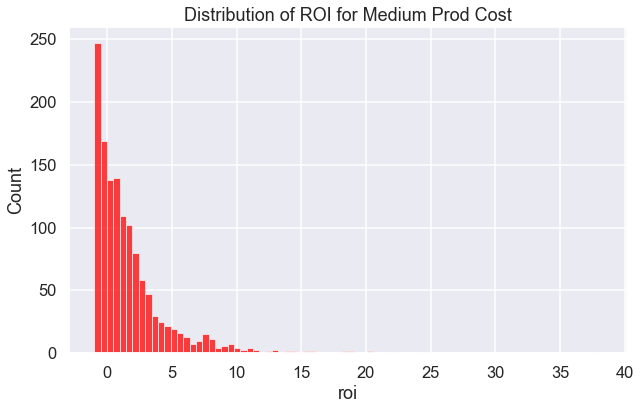

In [72]:
plt.figure(figsize=(10,6))
plt.title('Distribution of ROI for Medium Prod Cost')
sns.histplot(data=prod_med, x='roi', color='red');

In [73]:
# med outliers
print('10m < Budget < 100m')
print(f'95th percentile of ROI: {np.percentile(prod_med["roi"], 95):.2f}')
print(f'{100 - stats.percentileofscore(prod_med["roi"], 0):.1f}% break even (has ROI > {0})')
print(f'{100 - stats.percentileofscore(prod_med["roi"], 1):.1f}% make 100% profit (has ROI > {1})')

10m < Budget < 100m
95th percentile of ROI: 8.07
67.9% break even (has ROI > 0)
47.1% make 100% profit (has ROI > 1)


In [74]:
# med_films
prod_med['roi'].describe()

count   1,316.00
mean        1.80
std         3.41
min        -1.00
25%        -0.24
50%         0.81
75%         2.46
max        38.23
Name: roi, dtype: float64

In [75]:
# left 95%
med_95 = prod_med.query(" roi < 8.07 ").sort_values('roi', ascending=False)

print(f'{med_95.shape}')
med_95['roi'].describe()

(1250, 34)


count   1,250.00
mean        1.21
std         1.98
min        -1.00
25%        -0.30
50%         0.72
75%         2.17
max         8.05
Name: roi, dtype: float64

In [76]:
# right 5% (outliers)
med_5 = prod_med.query(" roi > 8.07 ").sort_values('roi', ascending=False)

print(f'{med_5.shape}')
med_5['roi'].describe()

(66, 34)


count   66.00
mean    12.91
std      5.37
min      8.11
25%      9.26
50%     10.95
75%     14.85
max     38.23
Name: roi, dtype: float64

### Med-budget films
- middle range of ROI (-1 - 38)
- exponential distribution

## Large-budget films:

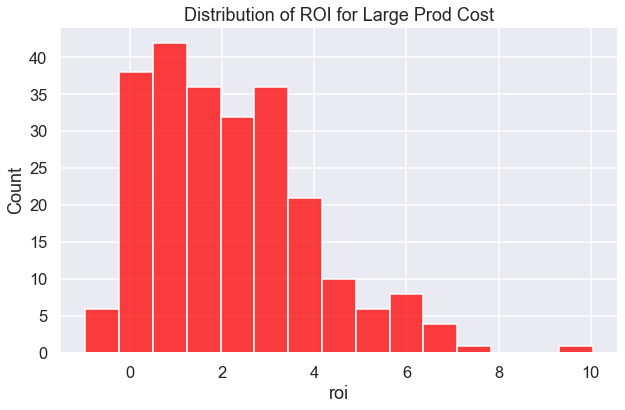

In [77]:
plt.figure(figsize=(10,6))
plt.title('Distribution of ROI for Large Prod Cost')
sns.histplot(data=prod_big, x='roi', color='red');

In [78]:
# large outliers
print('Budget >= 100m')
print(f'95th percentile of ROI: {np.percentile(prod_big["roi"], 95):.2f}')
print(f'{100 - stats.percentileofscore(prod_big["roi"], 0):.1f}% break even (has ROI > {0})')
print(f'{100 - stats.percentileofscore(prod_big["roi"], 1):.1f}% make 100% profit (has ROI > {1})')

Budget >= 100m
95th percentile of ROI: 5.74
92.9% break even (has ROI > 0)
72.6% make 100% profit (has ROI > 1)


In [79]:
prod_big['roi'].describe()

count   241.00
mean      2.18
std       1.79
min      -0.97
25%       0.86
50%       1.88
75%       3.21
max      10.04
Name: roi, dtype: float64

In [80]:
# left 95%
big_95 = prod_big.query(" roi < 5.74 ").sort_values('roi', ascending=False)

print(f'{big_95.shape}')
big_95['roi'].describe()

(228, 34)


count   228.00
mean      1.93
std       1.45
min      -0.97
25%       0.82
50%       1.78
75%       3.00
max       5.65
Name: roi, dtype: float64

In [81]:
# right 5% (outliers)
big_5 = prod_big.query(" roi > 5.74 ").sort_values('roi', ascending=False)

print(f'{big_5.shape}')
big_5['roi'].describe()

(13, 34)


count   13.00
mean     6.66
std      1.15
min      5.74
25%      5.83
50%      6.36
75%      6.87
max     10.04
Name: roi, dtype: float64

In [83]:
big_5[['title', 'primary_name', 'roi', 'genre', 'month', 'year']]

,title,primary_name,roi,genre,month,year
122280,Titanic,Ravi Punj,10.04,Family,12.00,"1,997.00"
7186,Frozen,Adam Green,7.48,Adventure Sport Thriller Drama,11.00,"2,013.00"
48400,Furious 7,James Wan,6.99,Thriller Action Crime,4.00,"2,015.00"
37732,Beauty and the Beast,Christophe Gans,6.87,Animation Drama Family Fantasy Romance,3.00,"2,017.00"
79984,Jurassic World: Fallen Kingdom,J.A. Bayona,6.68,Adventure Sci-Fi Action,6.00,"2,018.00"
67,Jurassic World,Colin Trevorrow,6.67,Adventure Sci-Fi Action Thriller,6.00,"2,015.00"
6681,Venom,Ruben Fleischer,6.36,Thriller Sci-Fi Action,10.00,"2,018.00"
9079,Aquaman,James Wan,6.17,Adventure Fantasy Action,12.00,"2,018.00"
87604,Deadpool 2,David Leitch,6.15,Comedy Adventure Action,5.00,"2,018.00"
129759,Avengers: Infinity War,NaN,5.83,Adventure Fantasy Action,4.00,"2,018.00"


### Large-budget films
- smallest range of ROI (-1 - 10)
- distibution is much more normal than small and medium films

# Don't think the next information is useful

In [84]:
df['num_genres'] = df['genre'].str.split().str.len()

In [158]:
df['num_genres'].mean()

2.7576519916142557

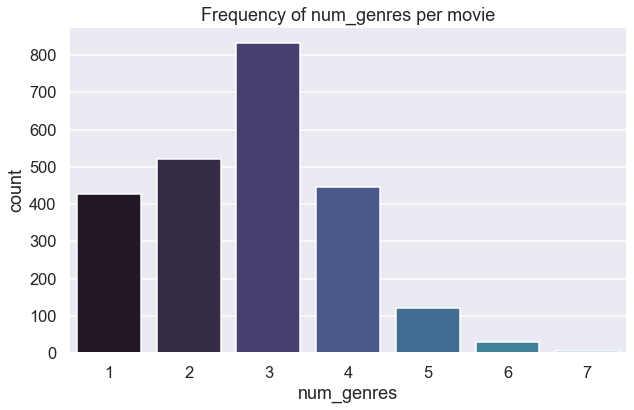

In [86]:
plt.figure(figsize=(10,6))
plt.title('Frequency of num_genres per movie')
sns.countplot(x=df['num_genres'], palette=palette);

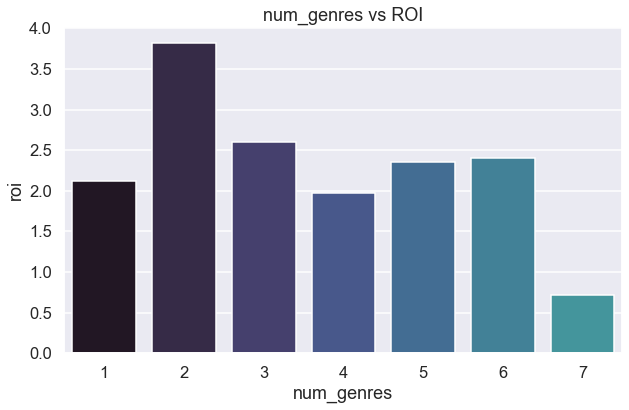

In [87]:
plt.figure(figsize=(10,6))
plt.title('num_genres vs ROI')
sns.barplot(x=df['num_genres'], y=df['roi'], ci=False, palette=palette);

# Look at distributions of movies with different production costs

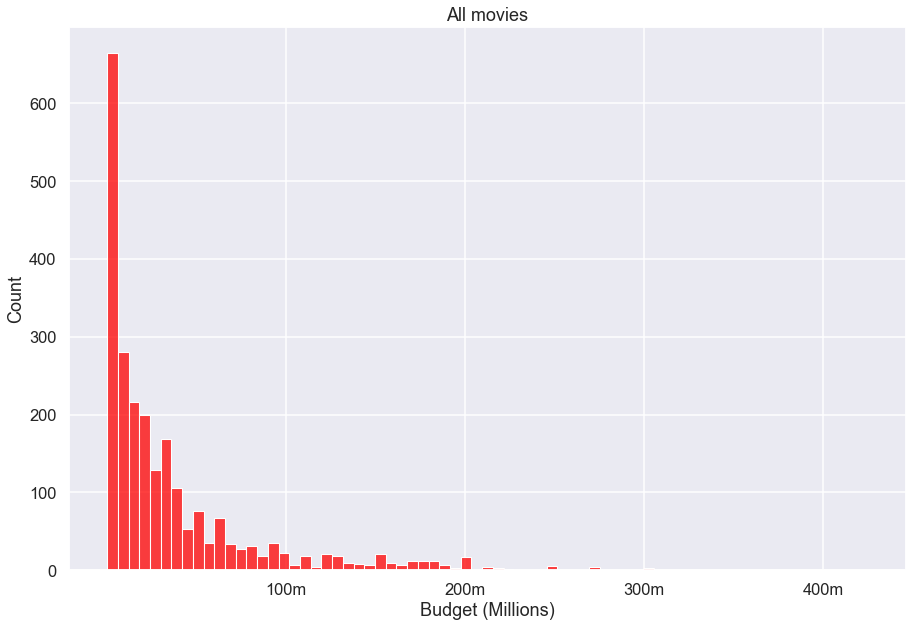

In [88]:
plt.figure(figsize=(15, 10))

sns.histplot(data=df, x='production_budget', color='red')

plt.title('All movies')
plt.ylabel('Count')
plt.xlabel('Budget (Millions)')

ticks = [1 * 1e8, 2 * 1e8, 3 * 1e8, 4 * 1e8]
plt.xticks(ticks=ticks, labels=['100m', '200m', '300m', '400m']);

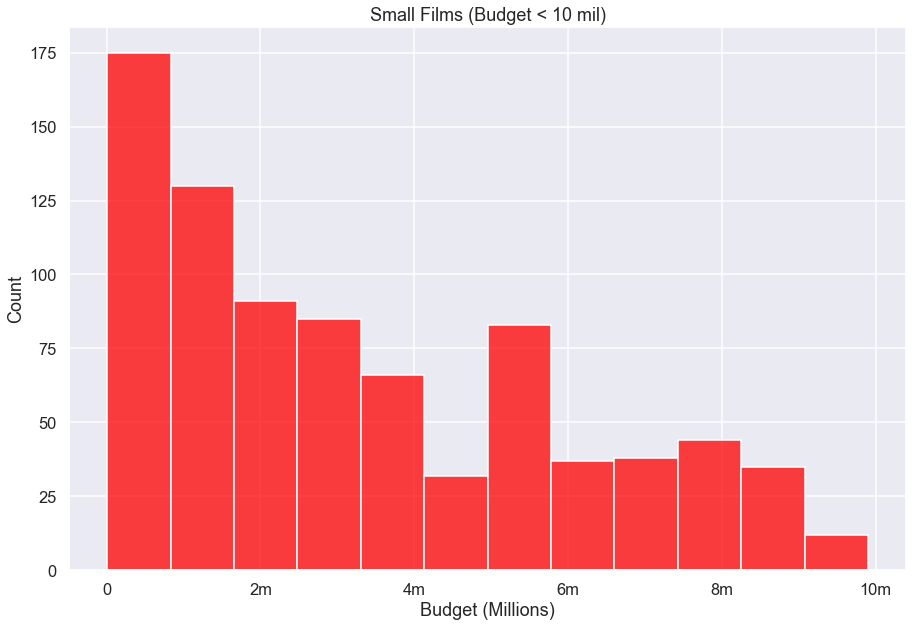

In [89]:
plt.figure(figsize=(15, 10))

sns.histplot(data=prod_small, x='production_budget', color='red')

plt.title('Small Films (Budget < 10 mil)')
plt.ylabel('Count')
plt.xlabel('Budget (Millions)')

ticks = [0 * 1e6, 2 * 1e6, 4 * 1e6, 6 * 1e6, 8 * 1e6, 1e7]
plt.xticks(ticks=ticks, labels=['0', '2m', '4m', '6m', '8m', '10m']);

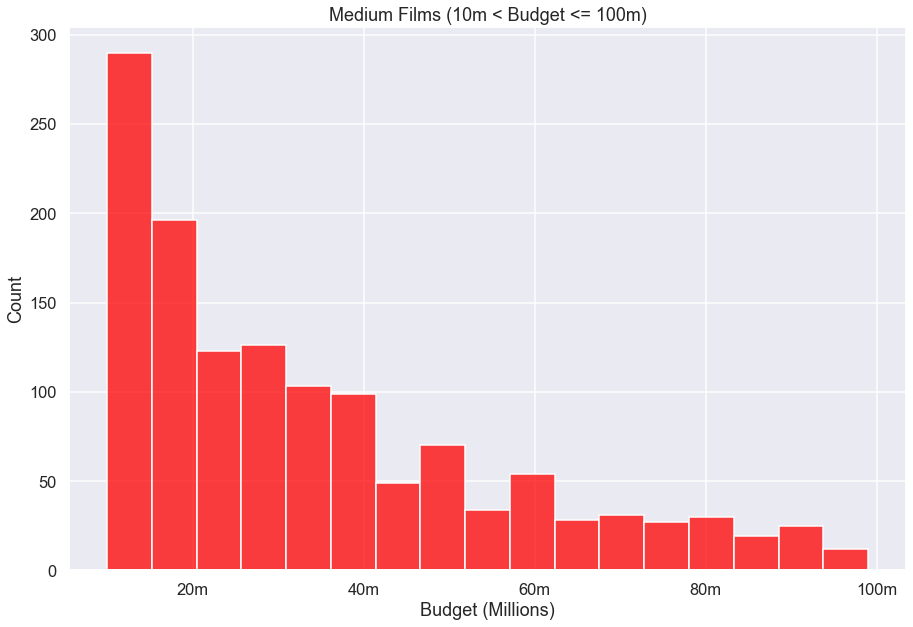

In [90]:
plt.figure(figsize=(15, 10))

sns.histplot(data=prod_med, x='production_budget', color='red')

plt.title('Medium Films (10m < Budget <= 100m)')
plt.ylabel('Count')
plt.xlabel('Budget (Millions)')

ticks = [2 * 1e7, 4 * 1e7, 6 * 1e7, 8 * 1e7, 1e8]
plt.xticks(ticks=ticks, labels=['20m', '40m', '60m', '80m', '100m']);

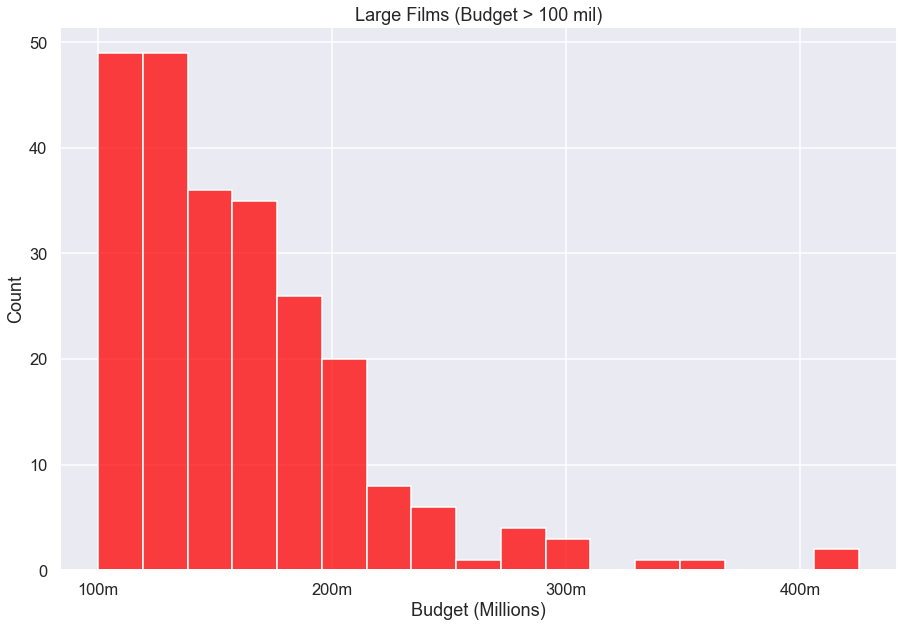

In [91]:
plt.figure(figsize=(15, 10))

sns.histplot(data=prod_big, x='production_budget', color='red')

ticks = [1 * 1e8, 2 * 1e8, 3 * 1e8, 4 * 1e8]
plt.xticks(ticks=ticks, labels=['100m', '200m', '300m', '400m'])

plt.title('Large Films (Budget > 100 mil)')
plt.ylabel('Count')
plt.xlabel('Budget (Millions)');

# Look at ROI for each genre

In [192]:
# for plotting; seperates mulitple-genre films into multiple rows
df_melted = df.melt(id_vars=['roi'], value_vars=genres, var_name='genre', value_name='is_genre')
df_melted = df_melted[df_melted['is_genre'] == 1].drop(['is_genre'], axis=1).sort_values('roi')

# drop 'movie' genre (10 rows)
df_melted = df_melted.drop(df_melted.query(" genre == 'movie' | genre == 'TV' ").index)
df_melted.shape

(6557, 2)

In [193]:
# get mean roi for each genre
genre_roi_means = df_melted.groupby('genre')['roi'].mean().to_frame().sort_index()
genre_roi_means.columns = ['mean_roi']
genre_roi_means

,mean_roi
genre,
Action,1.96
Adventure,1.86
Animation,4.07
Biography,3.83
Comedy,2.46
Crime,1.47
Documentary,3.51
Drama,2.02
Family,2.80


In [210]:
combined = p_prof_given_genre.merge(genre_roi_means, on='genre')

print('table before removing outliers:')
combined.sort_values('percent', ascending=False)

table before removing outliers:


,percent,mean_roi
genre,,
Animation,0.83,4.07
Family,0.80,2.80
Fantasy,0.77,2.13
Adventure,0.76,1.86
Sci-Fi,0.68,2.09
Action,0.68,1.96
Comedy,0.67,2.46
Mystery,0.65,4.11
Romance,0.63,2.32


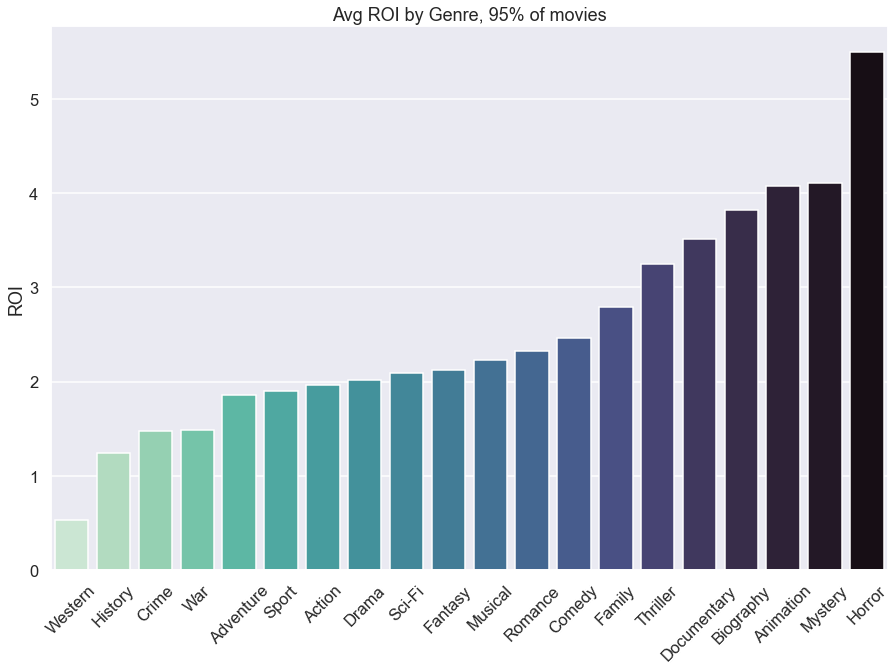

In [196]:
plt.figure(figsize=(15, 10))

sns.barplot(x=genre_roi_means.sort_values('mean_roi').index, y=genre_roi_means.sort_values('mean_roi')['mean_roi'], palette='mako_r')

plt.title('Avg ROI by Genre, 95% of movies')
plt.ylabel('ROI')
plt.xlabel('')
plt.xticks(rotation=45)

plt.savefig('plots/avg_roi_all_movies_95');

In [154]:
# prod_small
small_melted = prod_small.melt(id_vars=['roi'], value_vars=genres, var_name='genre', value_name='is_genre')
small_melted = small_melted[small_melted['is_genre'] == 1].drop(['is_genre'], axis=1).sort_values('roi')

small_melted = small_melted.drop(small_melted.query(" genre == 'movie' | genre == 'TV' ").index)

small_means = small_melted.groupby('genre')['roi'].mean().to_frame().sort_values('roi')

In [153]:
# prod_med
med_melted = prod_med.melt(id_vars=['roi'], value_vars=genres, var_name='genre', value_name='is_genre')
med_melted = med_melted[med_melted['is_genre'] == 1].drop(['is_genre'], axis=1).sort_values('roi')

med_melted = med_melted.drop(med_melted.query("genre == 'movie'").index)
med_melted.shape

med_means = med_melted.groupby('genre')['roi'].mean().to_frame().sort_values('roi')

In [151]:
# prod_big
big_melted = prod_big.melt(id_vars=['roi'], value_vars=genres, var_name='genre', value_name='is_genre')
big_melted = big_melted[big_melted['is_genre'] == 1].drop(['is_genre'], axis=1).sort_values('roi')

big_melted = big_melted.drop(big_melted.query("genre == 'movie'").index)

big_means = big_melted.groupby('genre')['roi'].mean().to_frame().sort_values('roi')

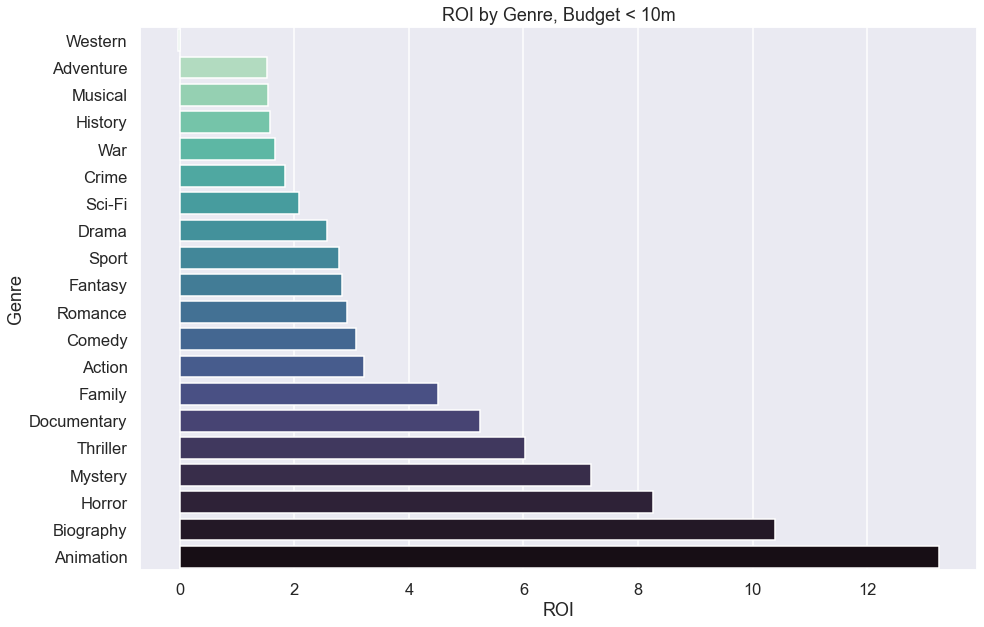

In [213]:
plt.figure(figsize=(15, 10))

sns.barplot(y=small_means.index, x=small_means['roi'], palette='mako_r')

plt.title('ROI by Genre, Budget < 10m')
plt.ylabel('Genre')
plt.xlabel('ROI')

plt.savefig('plots/roi_under10', dpi=150);

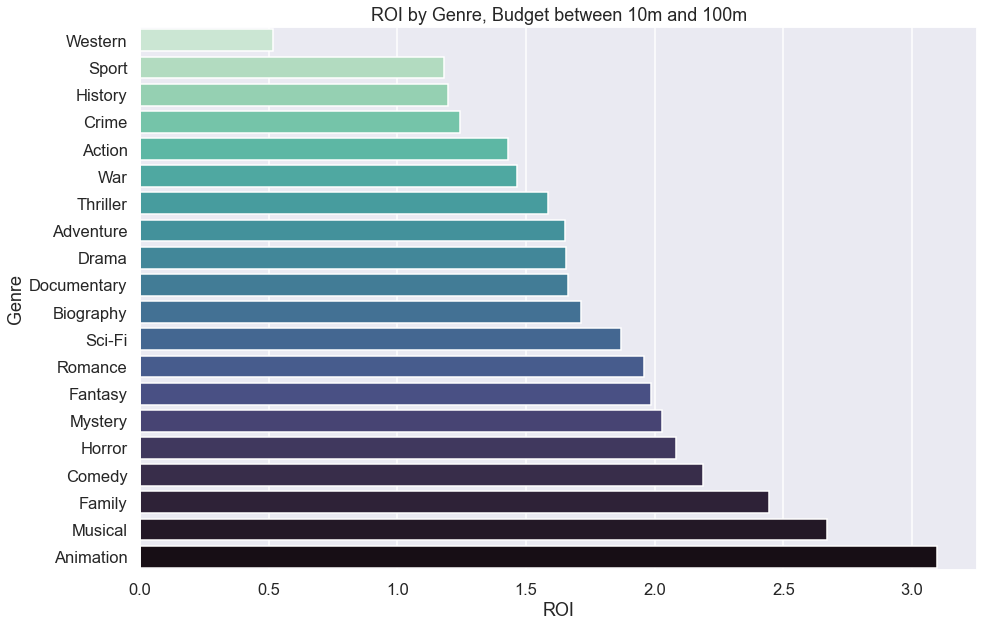

In [219]:
plt.figure(figsize=(15, 10))

sns.barplot(y=med_means.index, x=med_means['roi'], palette='mako_r')

plt.title('ROI by Genre, Budget between 10m and 100m')
plt.ylabel('Genre')
plt.xlabel('ROI')

plt.savefig('plots/roi_between', dpi=150);

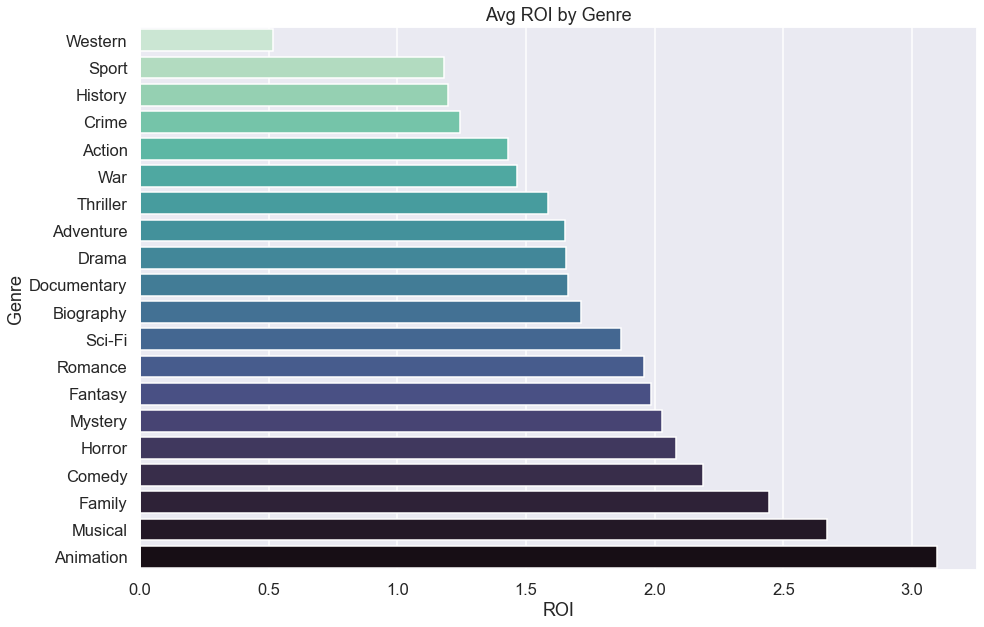

In [156]:
plt.figure(figsize=(15, 10))

sns.barplot(y=med_means.index, x=med_means['roi'], palette='mako_r')

plt.title('Avg ROI by Genre')
plt.ylabel('Genre')
plt.xlabel('ROI');

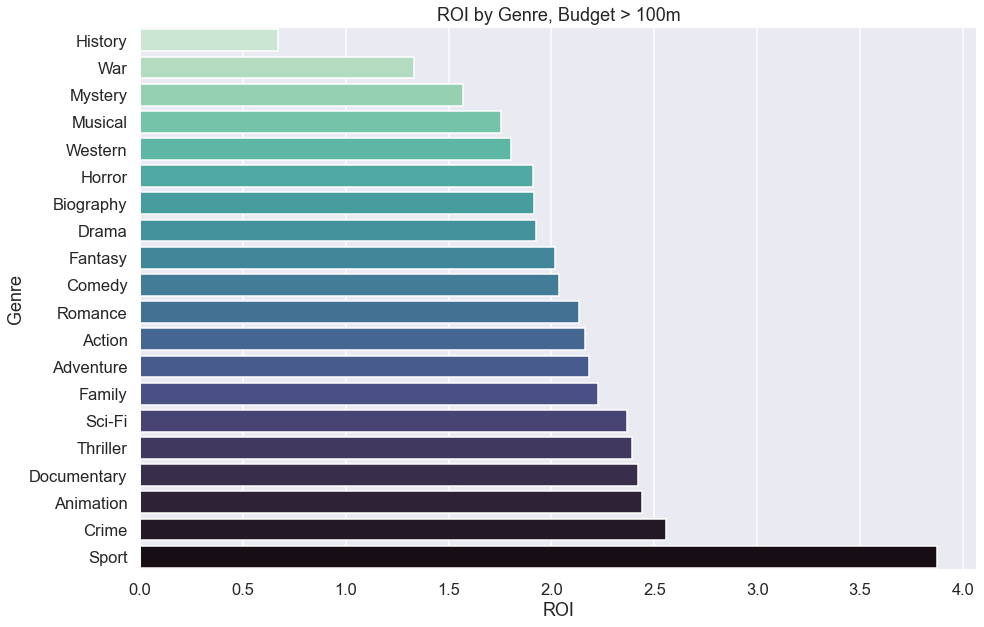

In [215]:
plt.figure(figsize=(15, 10))

sns.barplot(y=big_means.index, x=big_means['roi'], palette='mako_r')

plt.title('ROI by Genre, Budget > 100m')
plt.ylabel('Genre')
plt.xlabel('ROI')
plt.savefig('plots/roi_over100', dpi=150);